# Institutions, métiers, champs (en préparation)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [ ]:
###  Installation du widget jupyter en plus de la librairie
# jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-cytoscape
import ipycytoscape as cy

In [ ]:
import pprint
import csv
import ast
import re

from collections import Counter, defaultdict
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

## Base de données

In [ ]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [ ]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

In [ ]:
##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [ ]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

## Relations pendant les études

Personnes ayant étudié dans la même université dans une fourchette de 12 ans : on émet l'hypothèse que ils/elles ont virtuellement pu nouer des relations qui peuvent influences les parcours et choix ultérieurs grâce à des contacts prolongés avec d'anciens camarades d'études

In [ ]:
### 
#  On part de la date de naissance et on postule un croisement entre une et plusieurs années
# en admettant que l'âge des études soit approximativement le même

etudes_meme_uni = """
SELECT REPLACE(p.uri_entity , 'http://dbpedia.org/resource/', '') person_1,
REPLACE(p1.uri_entity , 'http://dbpedia.org/resource/', '') person_2,
REPLACE(p.value, 'http://dbpedia.org/resource/', '') alma_mater,
p2.value birth_year_1,
p3.value birth_year_2,
p4.value long,
p5.value lat
FROM property p
  JOIN property p1 ON p1.value = p.value AND p1.pk_property > p.pk_property AND p1.property LIKE '%almaMater'
  JOIN property p2 ON p2.uri_entity = p.uri_entity AND p2.property LIKE '%irthYe%' AND p2."source" LIKE '%8 mai 2021%'
  JOIN property p3 ON p3.uri_entity = p1.uri_entity AND p3.property LIKE '%irthYe%' AND p3."source" LIKE '%8 mai 2021%'
  LEFT JOIN property p4 ON
	p4.uri_entity = p1.value
	AND p4.property LIKE '%long'
LEFT JOIN property p5 ON
	p5.uri_entity = p1.value
	AND p5.property LIKE '%lat'
WHERE  p.property LIKE '%almaMater'
AND p3.value BETWEEN (p2.value - 6) AND (p2.value + 6);
"""

In [ ]:
### Undirected version of the same graph produced using Pandas
cn = sql.connect(db)
same_univ = pd.read_sql_query(etudes_meme_uni, cn)
cn.close()
same_univ.head()

In [ ]:
universities = same_univ.groupby(['alma_mater']).size()
print(len(universities))
list(universities.sort_values(ascending=False).items())[:100] #[10:20]

In [ ]:
fields par période

# Liens entre les Organisations

In [10]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [11]:
## liens entre Universités donnés par les étudiants
liens_univ = """
SELECT REPLACE(p.value , 'http://dbpedia.org/resource/', '') univ_1,
REPLACE(p1.value, 'http://dbpedia.org/resource/', '') univ_2,
REPLACE(p.uri_entity, 'http://dbpedia.org/resource/', '') person,
p3.value birth_year,
p4.value long,
p5.value lat,
p6.value long,
p7.value lat
FROM property p
  JOIN property p1 ON p1.uri_entity = p.uri_entity AND p1.pk_property > p.pk_property AND p1.property LIKE '%almaMater'
  JOIN property p3 ON p3.uri_entity = p1.uri_entity AND p3.property LIKE '%irthYe%' AND p3."source" LIKE '%8 mai 2021%'
  LEFT JOIN property p4 ON
	p4.uri_entity = p.value
	AND p4.property LIKE '%long'
	LEFT JOIN property p5 ON
	p5.uri_entity = p.value
	AND p5.property LIKE '%lat'
	LEFT JOIN property p6 ON
	p6.uri_entity = p1.value
	AND p6.property LIKE '%long'
LEFT JOIN property p7 ON
	p7.uri_entity = p1.value
	AND p7.property LIKE '%lat'
WHERE  p.property LIKE '%almaMater';
"""

In [12]:
### Undirected version of the same graph produced using Pandas
cn = sql.connect(db)
df_liens_univ = pd.read_sql_query(liens_univ, cn)
cn.close()
df_liens_univ.head()

,univ_1,univ_2,person,birth_year,long,lat,long,lat
0,Bangalore_University,Harvard_University,A._K._Shiva_Kumar,1956,77.5032,12.9388,-71.1169,42.3744
1,IIM_Ahmedabad,Harvard_University,A._K._Shiva_Kumar,1956,None,None,-71.1169,42.3744
2,"St._Joseph's_College,_Bangalore",Harvard_University,A._K._Shiva_Kumar,1956,77.5964,12.9629,-71.1169,42.3744
3,Bangalore_University,IIM_Ahmedabad,A._K._Shiva_Kumar,1956,77.5032,12.9388,None,None
4,Bangalore_University,"St._Joseph's_College,_Bangalore",A._K._Shiva_Kumar,1956,77.5032,12.9388,77.5964,12.9629


In [13]:
students = df_liens_univ.groupby(['person']).size()
print(len(students))
list(students.sort_values(ascending=False).items())[:10] #[10:20]

1299


[('Piet_Lieftinck', 28),
 ('Jo_Ritzen', 28),
 ('Hans_Sennholz', 21),
 ('Ian_Macfarlane_(economist)', 21),
 ('Alexander_Rinnooy_Kan', 21),
 ('B._R._Ambedkar', 21),
 ('Aat_van_Rhijn', 21),
 ('Jan_Kees_de_Jager', 21),
 ('Andreas_Kaplan', 15),
 ('Oliver_E._Williamson', 15)]

In [ ]:
## Piet_Lieftinck 8 universities but errors 


In [14]:
df_students = pd.DataFrame(students, columns=['eff'])
gdf_students = df_students.groupby(['eff']).size()
gdf_students.sort_index(ascending=False)[:20]

eff
28      2
21      6
15      4
10     21
6      85
3     355
1     826
dtype: int64

In [15]:
GU = nx.from_pandas_edgelist(df_liens_univ, 'univ_1', 'univ_2')
type(GU)

networkx.classes.graph.Graph

In [ ]:
### CA DOIT être un multigraphe !

In [16]:
GU.is_multigraph(), GU.is_directed(), GU.number_of_nodes(), GU.number_of_edges(), nx.is_connected(GU), nx.density(GU)

(False, False, 1071, 2323, False, 0.004054207352723021)

In [17]:
nx.number_connected_components(GU)

72

In [18]:
### Composantes du graphe
# Une composante principale avec 1505 individus et de multiples petites composantes
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
c_comp = nx.connected_components(GU)
print(type(c_comp))
## Length of generator as set of nodes = number of nodes
df_c_comp = pd.DataFrame([len(c) for c in sorted(c_comp, key=len, reverse=True)], columns=['eff'])
gs_c_comp = df_c_comp.groupby(['eff']).size()
gs_c_comp.sort_index()

<class 'generator'>


eff
2      57
3      10
4       4
911     1
dtype: int64

In [19]:
#  https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
print([c for c in c_comp if len(c) == 3])
S = [[len(c), GU.subgraph(c).copy()] for c in nx.connected_components(GU)]
# type(S)

[]


In [20]:
au = [[s[0], s[1]] for s in S  if s[0] == 4]
len(au)
#a

4

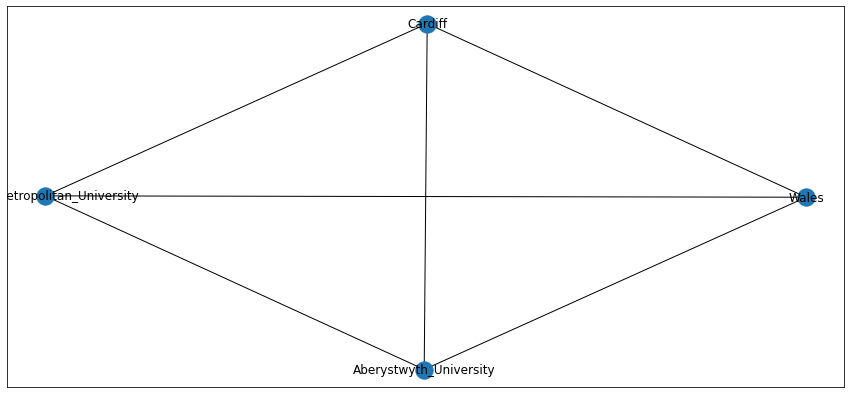

In [21]:
plt.figure(figsize=(15,7))
nx.draw_networkx(au[0][1])

In [ ]:
fig = plt.figure(figsize=(200,100))
pos = nx.kamada_kawai_layout(GU)
nx.draw_networkx(GU, pos, node_color = 'DarkBlue', font_color = 'CornflowerBlue',\
                 font_size=30, node_size=node_sizes, edge_color='LightGray' )
plt.savefig("graphs/GU.pdf", format="pdf")
plt.show()